# やること

- 実機による学習(notebooks/note17.ipynb をベースに)
- 正解のパラメータでシミュレーションして比較する
- プロット数調整する
- GRU との調和も試したい


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchview import draw_graph

from actual_machine_notebooks.note1.src.load_data import load_data_path0, path_list
from actual_machine_notebooks.note1.src.model import BuckConverterCell, GRUModel

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

np.random.seed(seed)

In [2]:
keep_log = True  # 結果保存するかどうか

data_path = path_list.path0

# 真値パラメータ（すべてのデータセットで共通）
L_true: float = 100e-6
C_true: float = 48e-6
R_true: float = 10

Vin = 10
Vref = 6
duty = Vref / Vin
f_sw = 1e5  # スイッチング周波数
T = 1 / f_sw  # 1周期の実時間

train_ratio = 0.3
valid_ratio = 0.3
# test_ratio = 1 - train_ratio - valid_ratio

# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 5e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 1000

# GRU学習用のデータ準備（時系列データ）
seq_length = 10

gru_lr = 0.001
gru_epochs = 200


# 実機データの前処理


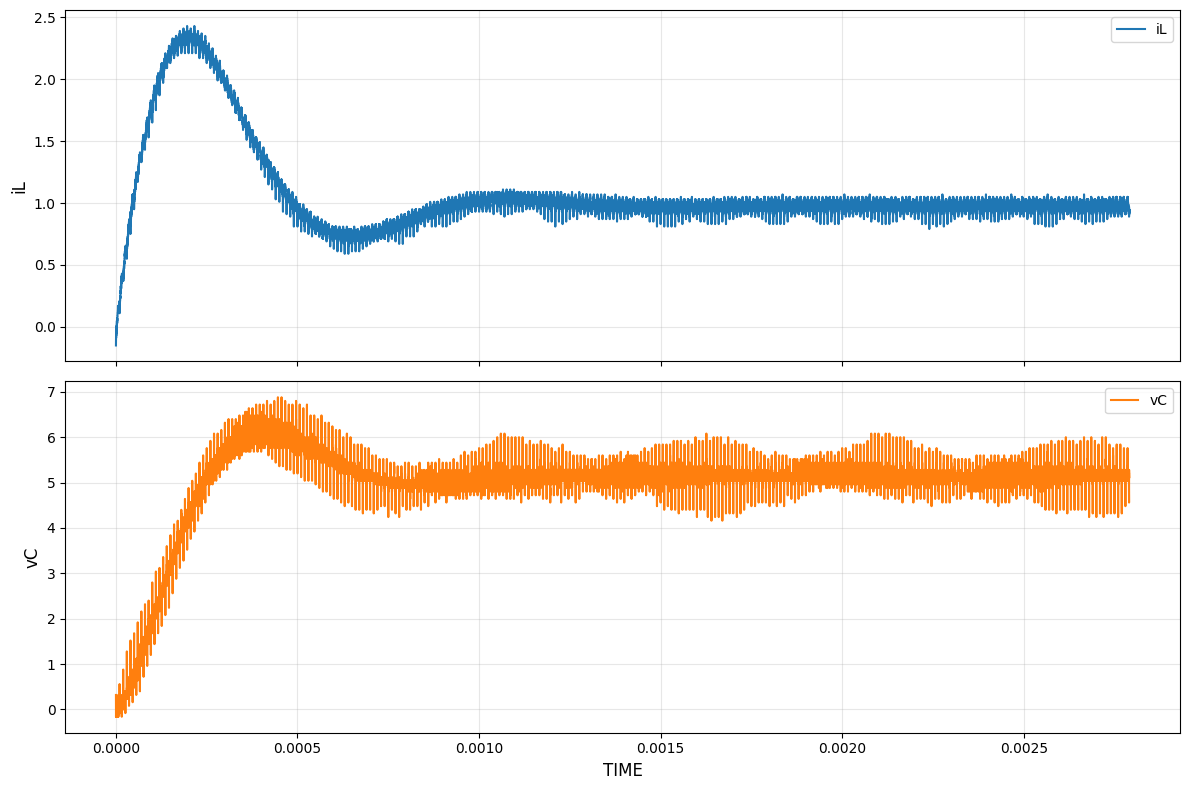

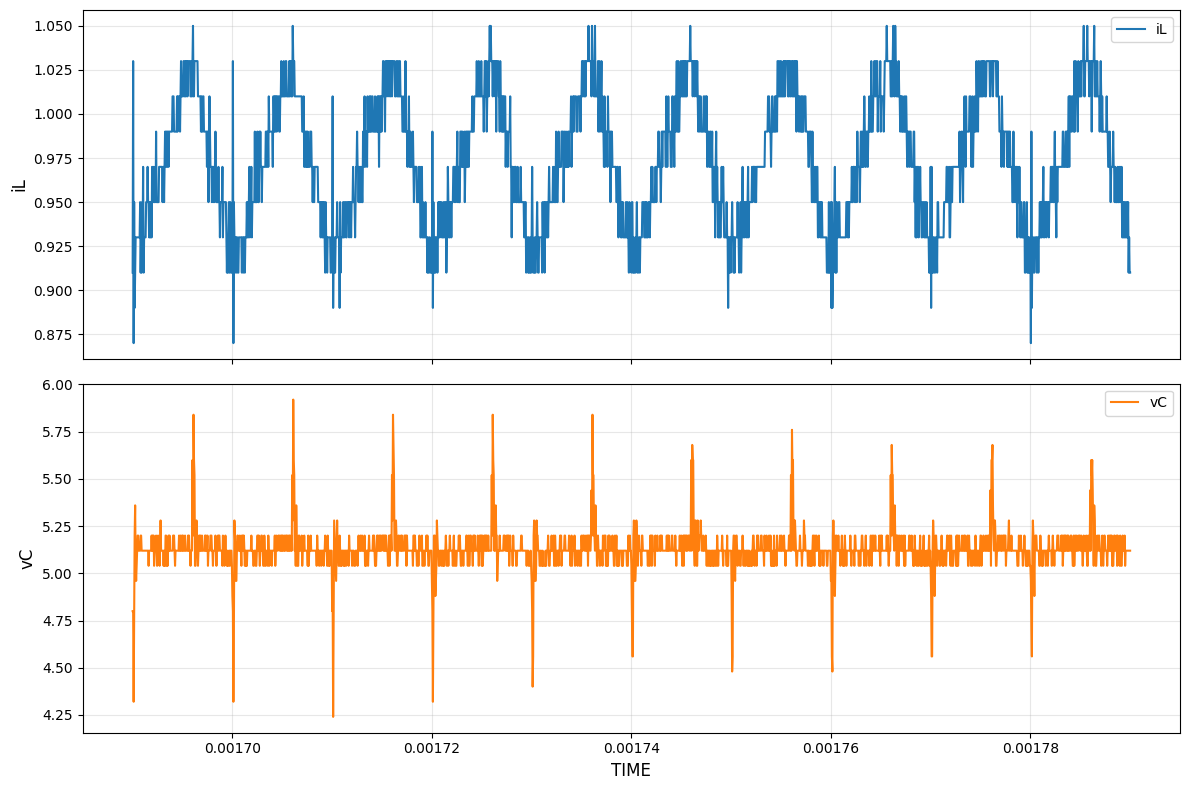

In [3]:
t_all, iL_all, vC_all = load_data_path0()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 上段: iL（上のセルの色に合わせる）
ax1.plot(t_all, iL_all, color="tab:blue", linewidth=1.5, label="iL")
ax1.set_ylabel("iL", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="best")

# 下段: vC（上のセルの色に合わせる）
ax2.plot(t_all, vC_all, color="tab:orange", linewidth=1.5, label="vC")
ax2.set_ylabel("vC", fontsize=12)
ax2.set_xlabel("TIME", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()

# 定常状態っぽいところを10周期分だけ切り出す
start_t, end_t = 0.00169, 0.00179
mask: np.ndarray = (start_t <= t_all) & (t_all <= end_t)
t = t_all[mask]
iL = iL_all[mask]
vC = vC_all[mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 上段: iL（上のセルの色に合わせる）
ax1.plot(t, iL, color="tab:blue", linewidth=1.5, label="iL")
ax1.set_ylabel("iL", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="best")

# 下段: vC（上のセルの色に合わせる）
ax2.plot(t, vC, color="tab:orange", linewidth=1.5, label="vC")
ax2.set_ylabel("vC", fontsize=12)
ax2.set_xlabel("TIME", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()


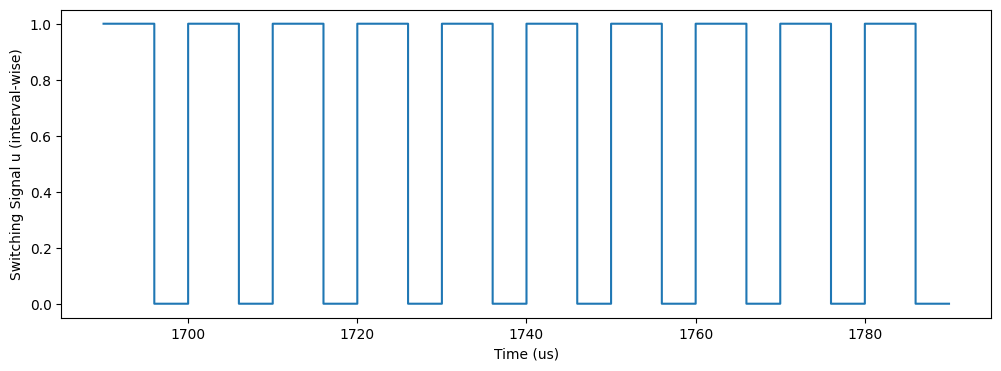

In [4]:
# スイッチング信号
duty_phase = (t[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t) - 1) * Vin

# プロット
plt.figure(figsize=(12, 4))
plt.step(t[:-1] * 1e6, u, where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u (interval-wise)")
plt.show()

In [5]:
# train, valid, test の分割
dt = t[1:] - t[:-1]

# numpy配列をテンソルに変換
dt_tensor = torch.tensor(dt, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
vs_tensor = torch.tensor(vs, dtype=torch.float32)
iL_tensor = torch.tensor(iL, dtype=torch.float32)
vC_tensor = torch.tensor(vC, dtype=torch.float32)

# train
train_len = int(len(dt) * train_ratio)

t_train = t[: train_len + 1]
dt_train = dt_tensor[:train_len]
u_train = u_tensor[:train_len]
vs_train = vs_tensor[:train_len]
iL_train = iL_tensor[: train_len + 1]
vC_train = vC_tensor[: train_len + 1]

h_train = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)
x_train = torch.stack([vs_train, u_train, dt_train], dim=1)
target_train = torch.stack([iL_train[1:], vC_train[1:]], dim=1)


# valid
valid_len = int(len(dt) * valid_ratio)

t_valid = t[train_len : train_len + valid_len]
dt_valid = dt_tensor[train_len : train_len + valid_len]
u_valid = u_tensor[train_len : train_len + valid_len]
vs_valid = vs_tensor[train_len : train_len + valid_len]
iL_valid = iL_tensor[train_len : train_len + valid_len + 1]
vC_valid = vC_tensor[train_len : train_len + valid_len + 1]

h_valid = torch.stack([iL_valid[:-1], vC_valid[:-1]], dim=1)
x_valid = torch.stack([vs_valid, u_valid, dt_valid], dim=1)
target_valid = torch.stack([iL_valid[1:], vC_valid[1:]], dim=1)

# test
t_test = t[train_len + valid_len :]
dt_test = dt_tensor[train_len + valid_len :]
u_test = u_tensor[train_len + valid_len :]
vs_test = vs_tensor[train_len + valid_len :]
iL_test = iL_tensor[train_len + valid_len :]
vC_test = vC_tensor[train_len + valid_len :]

h_test = torch.stack([iL_test[:-1], vC_test[:-1]], dim=1)
x_test = torch.stack([vs_test, u_test, dt_test], dim=1)
target_test = torch.stack([iL_test[1:], vC_test[1:]], dim=1)


print(f"{h_train.shape=}")
print(f"{x_train.shape=}")
print(f"{target_train.shape=}")

print(f"{h_valid.shape=}")
print(f"{x_valid.shape=}")
print(f"{target_valid.shape=}")

print(f"{h_test.shape=}")
print(f"{x_test.shape=}")
print(f"{target_test.shape=}")


h_train.shape=torch.Size([600, 2])
x_train.shape=torch.Size([600, 3])
target_train.shape=torch.Size([600, 2])
h_valid.shape=torch.Size([600, 2])
x_valid.shape=torch.Size([600, 3])
target_valid.shape=torch.Size([600, 2])
h_test.shape=torch.Size([800, 2])
x_test.shape=torch.Size([800, 3])
target_test.shape=torch.Size([800, 2])


# Buck Converter Cell の学習


In [6]:
buck_converter_cell = BuckConverterCell(L_init=L_init, C_init=C_init, R_init=R_init)

optimizer = optim.Adam(
    [
        {"params": [buck_converter_cell.log_L], "lr": lr_L},
        {"params": [buck_converter_cell.log_C], "lr": lr_C},
        {"params": [buck_converter_cell.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

# 損失履歴を保存
loss_history = {"train": [], "valid": []}
param_history = {"L": [], "C": [], "R": []}

# 学習ループ
for epoch in range(epochs):
    # 学習モード
    buck_converter_cell.train()
    optimizer.zero_grad()
    h_pred_train = buck_converter_cell(h_train, x_train)
    train_loss = loss_fn(h_pred_train, target_train)
    train_loss.backward()
    optimizer.step()

    loss_history["train"].append(train_loss.item())

    # 検証モード（勾配計算なし）
    buck_converter_cell.eval()
    with torch.no_grad():
        h_pred_valid = buck_converter_cell(h_valid, x_valid)
        valid_loss = loss_fn(h_pred_valid, target_valid)
        loss_history["valid"].append(valid_loss.item())

    # パラメータの履歴を保存
    param_history["L"].append(buck_converter_cell.log_L.exp().item())
    param_history["C"].append(buck_converter_cell.log_C.exp().item())
    param_history["R"].append(buck_converter_cell.log_R.exp().item())

    if epoch % 50 == 0:
        output_line = (
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}\n"
            f"  L={buck_converter_cell.log_L.exp().item() * 1e6:.1f}µH "
            f"(true={L_true * 1e6:.1f})"
            f"C={buck_converter_cell.log_C.exp().item() * 1e6:.1f}µF "
            f"(true={C_true * 1e6:.1f})"
            f"R={buck_converter_cell.log_R.exp().item():.2f}Ω "
            f"(true={R_true:.1f})"
        )
        print(output_line)

# テストデータでの評価
buck_converter_cell.eval()
with torch.no_grad():
    h_pred_test = buck_converter_cell(h_test, x_test)
    test_loss = loss_fn(h_pred_test, target_test)

print(f"Final test loss: {test_loss.item():.6e}")


Epoch 0: Train Loss=7.068512e-03, Valid Loss=6.516753e-03
  L=209.9µH (true=100.0)C=99.0µF (true=48.0)R=7.85Ω (true=10.0)
Epoch 50: Train Loss=7.067361e-03, Valid Loss=6.515666e-03
  L=243.5µH (true=100.0)C=56.2µF (true=48.0)R=2.70Ω (true=10.0)
Epoch 100: Train Loss=7.066565e-03, Valid Loss=6.514834e-03
  L=246.5µH (true=100.0)C=30.9µF (true=48.0)R=3.08Ω (true=10.0)
Epoch 150: Train Loss=7.064489e-03, Valid Loss=6.512535e-03
  L=246.5µH (true=100.0)C=13.7µF (true=48.0)R=4.03Ω (true=10.0)
Epoch 200: Train Loss=7.057783e-03, Valid Loss=6.505079e-03
  L=246.5µH (true=100.0)C=4.9µF (true=48.0)R=4.76Ω (true=10.0)
Epoch 250: Train Loss=7.032624e-03, Valid Loss=6.477040e-03
  L=246.5µH (true=100.0)C=1.4µF (true=48.0)R=5.07Ω (true=10.0)
Epoch 300: Train Loss=6.931834e-03, Valid Loss=6.363704e-03
  L=246.5µH (true=100.0)C=0.3µF (true=48.0)R=5.25Ω (true=10.0)
Epoch 350: Train Loss=6.671753e-03, Valid Loss=6.066221e-03
  L=246.5µH (true=100.0)C=0.1µF (true=48.0)R=5.29Ω (true=10.0)
Epoch 400: Trai

# GRU の学習


In [7]:
# 前処理
buck_converter_cell.eval()
with torch.no_grad():
    # 学習データのノイズ計算
    h_pred_train = [h_train[0].unsqueeze(0)]
    for j in range(len(h_train) - 1):
        h_current = buck_converter_cell(h_pred_train[-1], x_train[j : j + 1])
        h_pred_train.append(h_current)
    h_pred_train = torch.cat(h_pred_train, dim=0)
    noise_train = target_train - h_pred_train

    # 検証データのノイズ計算
    h_pred_valid = [h_valid[0].unsqueeze(0)]
    for j in range(len(h_valid) - 1):
        h_current = buck_converter_cell(h_pred_valid[-1], x_valid[j : j + 1])
        h_pred_valid.append(h_current)
    h_pred_valid = torch.cat(h_pred_valid, dim=0)
    noise_valid = target_valid - h_pred_valid

    # テストデータのノイズ計算
    h_pred_test = [h_test[0].unsqueeze(0)]
    for j in range(len(h_test) - 1):
        h_current = buck_converter_cell(h_pred_test[-1], x_test[j : j + 1])
        h_pred_test.append(h_current)
    h_pred_test = torch.cat(h_pred_test, dim=0)
    noise_test = target_test - h_pred_test

    # 全データのノイズを結合
    noise_all = torch.cat([noise_train, noise_valid, noise_test], dim=0)


def create_sequences(
    h_data: torch.Tensor,
    x_data: torch.Tensor,
    noise_data: torch.Tensor,
    seq_len: int,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    時系列データを作成
    入力: [iL, vC, vs, u, dt, iL_noise, vC_noise]
    出力: [iL_noise, vC_noise]
    """
    sequences = []
    targets = []

    for i in range(len(h_data) - seq_len):
        # 入力特徴量: [iL, vC, vs, u, dt] + 過去のノイズ [iL_noise, vC_noise]
        seq_input = []
        for j in range(seq_len):
            idx = i + j
            # 状態と入力
            features = torch.cat(
                [
                    h_data[idx],  # [iL, vC]
                    x_data[idx],  # [vs, u, dt]
                ]
            )
            # 過去のノイズ（存在する場合）
            if idx > 0:
                noise_features = noise_data[idx - 1]  # [iL_noise, vC_noise]
            else:
                noise_features = torch.zeros(2)
            # 結合: [iL, vC, vs, u, dt, iL_noise, vC_noise] = 7次元
            combined = torch.cat([features, noise_features])
            seq_input.append(combined)

        sequences.append(torch.stack(seq_input))
        targets.append(noise_data[i + seq_len])

    return torch.stack(sequences), torch.stack(targets)


# データセットを作成
X_train_seq, y_train_seq = create_sequences(
    h_train, x_train, noise_all[: len(h_train)], seq_length
)
X_valid_seq, y_valid_seq = create_sequences(
    h_valid, x_valid, noise_all[len(h_train) : len(h_train) + len(h_valid)], seq_length
)
X_test_seq, y_test_seq = create_sequences(
    h_test, x_test, noise_all[len(h_train) + len(h_valid) :], seq_length
)

print(f"学習データ: {X_train_seq.shape} -> {y_train_seq.shape}")
print(f"検証データ: {X_valid_seq.shape} -> {y_valid_seq.shape}")
print(f"テストデータ: {X_test_seq.shape} -> {y_test_seq.shape}")
print(
    f"入力特徴量の次元: {X_train_seq.shape[2]} (iL, vC, vs, u, dt, iL_noise, vC_noise)"
)

学習データ: torch.Size([590, 10, 7]) -> torch.Size([590, 2])
検証データ: torch.Size([590, 10, 7]) -> torch.Size([590, 2])
テストデータ: torch.Size([790, 10, 7]) -> torch.Size([790, 2])
入力特徴量の次元: 7 (iL, vC, vs, u, dt, iL_noise, vC_noise)


In [8]:
# 学習
gru_model = GRUModel(
    input_size=X_train_seq.shape[2],
    hidden_size=32,
    num_layers=2,
    output_size=2,
    seq_length=seq_length,
)


gru_optimizer = optim.Adam(gru_model.parameters(), lr=gru_lr)
gru_loss_fn = nn.MSELoss()

gru_loss_history = {"train": [], "valid": []}

for epoch in range(gru_epochs):
    # 学習モード
    gru_model.train()
    gru_optimizer.zero_grad()
    noise_pred_train = gru_model(X_train_seq)
    train_loss = gru_loss_fn(noise_pred_train, y_train_seq)
    train_loss.backward()
    gru_optimizer.step()

    gru_loss_history["train"].append(train_loss.item())

    # 検証モード
    gru_model.eval()
    with torch.no_grad():
        noise_pred_valid = gru_model(X_valid_seq)
        valid_loss = gru_loss_fn(noise_pred_valid, y_valid_seq)
        gru_loss_history["valid"].append(valid_loss.item())

    if (epoch + 1) % 50 == 0:
        print(
            f"Epoch {epoch + 1}/{gru_epochs}: "
            f"Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}"
        )


Epoch 50/200: Train Loss=1.833379e-02, Valid Loss=1.711235e-02
Epoch 100/200: Train Loss=1.130067e-02, Valid Loss=1.043616e-02
Epoch 150/200: Train Loss=6.241059e-03, Valid Loss=5.666067e-03
Epoch 200/200: Train Loss=5.971210e-03, Valid Loss=5.428622e-03


# 結果


In [9]:
import sys

sys.path.append("../..")


from src.utils.save_log import (
    create_result_dir,
    init_log,
    save_figure_to_log,
    save_graphviz_to_log,
    save_text_output,
)

config_dict = {
    "L_true": L_true,
    "C_true": C_true,
    "R_true": R_true,
    "Vin": Vin,
    "Vref": Vref,
    "duty": duty,
    "f_sw": f_sw,
    "T": T,
    "train_ratio": train_ratio,
    "valid_ratio": valid_ratio,
    "L_init": L_init,
    "C_init": C_init,
    "R_init": R_init,
    "lr_L": lr_L,
    "lr_C": lr_C,
    "lr_R": lr_R,
    "epochs": epochs,
    "seq_length": seq_length,
    "gru_lr": gru_lr,
    "gru_epochs": gru_epochs,
}
# ログ保存の初期化
if keep_log:
    result_dir = create_result_dir(
        "note1",
        base_dir="results/actual",
        config_dict=config_dict,
    )
    log_path = init_log(result_dir, "actual_machine_notebooks/note1/note1.ipynb")

In [10]:
final_train_loss = loss_history["train"][-1]
final_valid_loss = loss_history["valid"][-1]
final_test_loss = test_loss.item()

final_L = param_history["L"][-1]
final_C = param_history["C"][-1]
final_R = param_history["R"][-1]

cycles = round((t[-1] - t[0]) / T)

# 実験設定の表示
result_text = []
result_text.append("=== Buck Converter Cell ===")
result_text.append("")
result_text.append("【回路パラメータ】")
# result_text.append(
#     f"  真の値: L = {L_true:.6e} [H], C = {C_true:.6e} [F], R = {R_true:.3f} [Ω]"
# )
result_text.append(
    f"  初期値: L = {L_init:.6e} [H], C = {C_init:.6e} [F], R = {R_init:.3f} [Ω]"
)
result_text.append(
    f"  推論値: L = {final_L:.6e} [H], C = {final_C:.6e} [F], R = {final_R:.3f} [Ω]"
)
result_text.append("")
result_text.append("【入力条件】")
result_text.append(
    f"  Vin (入力電圧) = {Vin:.2f} [V], Vref (目標電圧) = {Vref:.2f} [V]"
)
result_text.append(f"  スイッチング周波数 f_sw = {f_sw:.0f} [Hz]")
result_text.append(f"  1周期あたりのプロット数 = {len(t) // cycles}")
result_text.append("")
result_text.append("【データ分割】")
result_text.append(
    f"  シミュレーション時間: {cycles}周期 = {(t[-1] - t[0]) * 1e6:.1f}μs"
)
result_text.append(f"  学習データ: {train_len} ステップ")
result_text.append(f"  検証データ: {valid_len} ステップ")
result_text.append(f"  テストデータ: {len(t) - train_len - valid_len} ステップ")
result_text.append("")
result_text.append("【最終Loss】")
result_text.append(f"  学習データ: {final_train_loss:.6e}")
result_text.append(f"  検証データ: {final_valid_loss:.6e}")
result_text.append(f"  テストデータ: {final_test_loss:.6e}")
result_text.append("")
result_text.append("【学習設定】")
result_text.append(f"  エポック数: {epochs}")
result_text.append(f"  学習率: L = {lr_L:.2e}, C = {lr_C:.2e}, R = {lr_R:.2e}")

result_text.append("=== GRU ===")
result_text.append(f"  エポック数: {gru_epochs}")
result_text.append(f"  学習率: {gru_lr:.2e}")

result_output = "\n".join(result_text)
print(result_output)

# 結果をログに保存
if keep_log:
    save_text_output(result_dir, result_output, "最終結果")


=== Buck Converter Cell ===

【回路パラメータ】
  初期値: L = 2.000000e-04 [H], C = 1.000000e-04 [F], R = 8.000 [Ω]
  推論値: L = 2.464634e-04 [H], C = 6.074582e-08 [F], R = 5.267 [Ω]

【入力条件】
  Vin (入力電圧) = 10.00 [V], Vref (目標電圧) = 6.00 [V]
  スイッチング周波数 f_sw = 100000 [Hz]
  1周期あたりのプロット数 = 200

【データ分割】
  シミュレーション時間: 10周期 = 100.0μs
  学習データ: 600 ステップ
  検証データ: 600 ステップ
  テストデータ: 801 ステップ

【最終Loss】
  学習データ: 6.635875e-03
  検証データ: 6.009395e-03
  テストデータ: 5.414745e-03

【学習設定】
  エポック数: 1000
  学習率: L = 5.00e-02, C = 1.00e-02, R = 2.00e-02
=== GRU ===
  エポック数: 200
  学習率: 1.00e-03


## Buck Converter Cell


In [11]:
if keep_log:
    model = BuckConverterCell(L_init=1, C_init=1, R_init=1)

    # ダミーデータを作成
    dummy_time_step = 10
    h_dummy = torch.randn(dummy_time_step, 2)
    x_dummy = torch.randn(dummy_time_step, 3)

    model_graph = draw_graph(
        model,
        input_data=[h_dummy, x_dummy],
        expand_nested=True,
    )

    # グラフを保存してログに追加
    save_graphviz_to_log(
        graphviz_graph=model_graph.visual_graph,
        filename="buck_converter_cell",
        result_dir=result_dir,
        title="Buck Converter Cell モデル構造",
    )

    model = GRUModel(
        input_size=X_train_seq.shape[2],
        hidden_size=32,
        num_layers=2,
        output_size=2,
        seq_length=seq_length,
    )

    model_graph = draw_graph(
        model,
        input_data=[X_train_seq],
        expand_nested=True,
    )

    # グラフを保存してログに追加
    save_graphviz_to_log(
        graphviz_graph=model_graph.visual_graph,
        filename="gru",
        result_dir=result_dir,
        title="GRU モデル構造",
    )


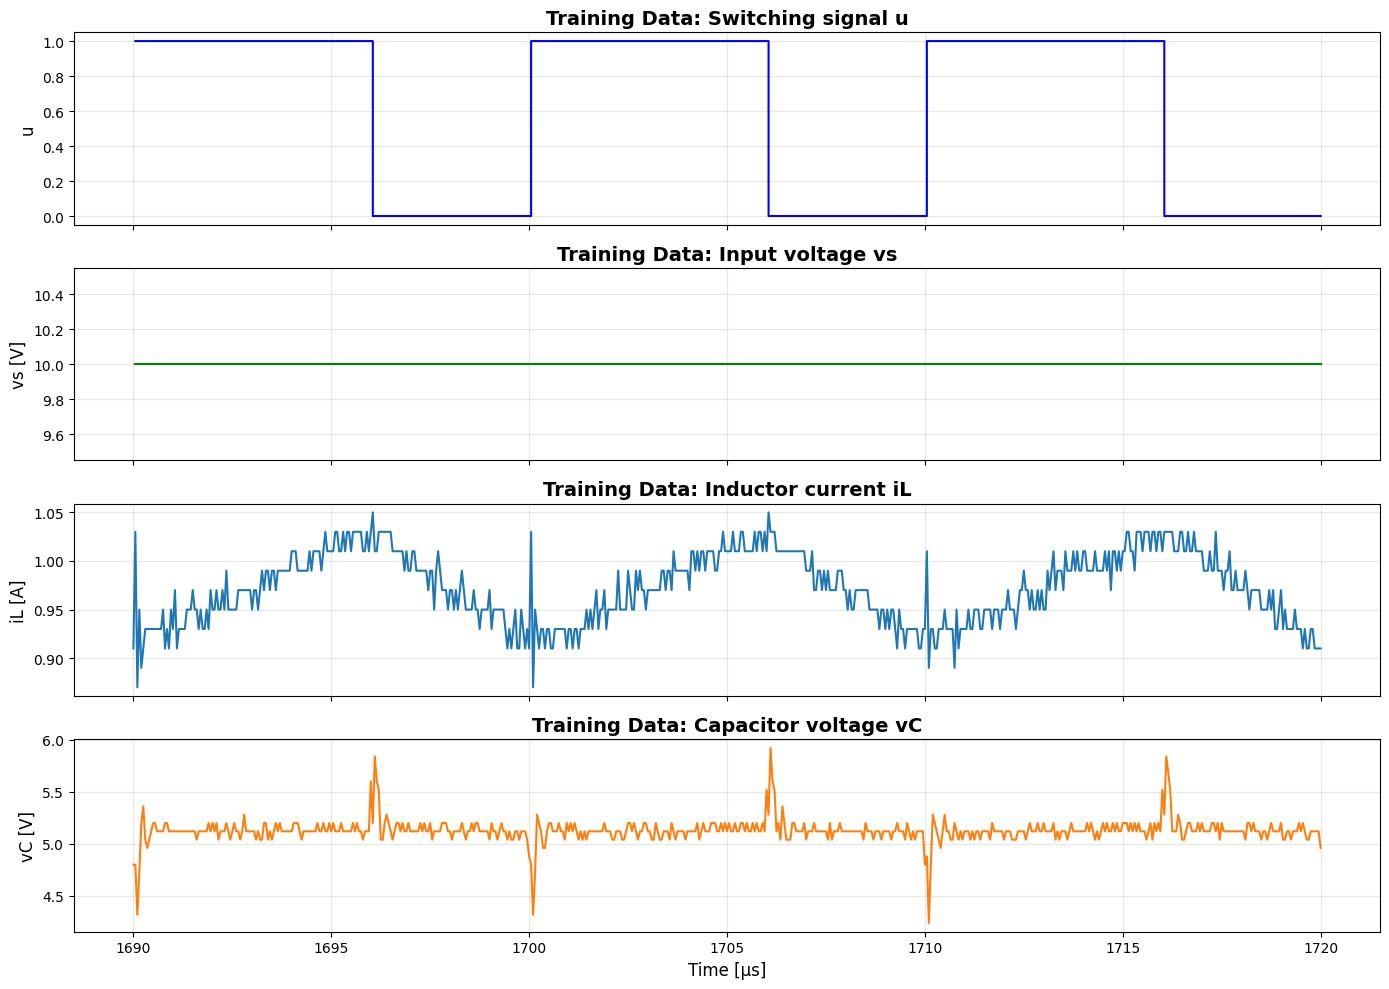

In [12]:
# 学習に使ったデータ
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t_train[1:] * 1e6, u_train, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u", fontsize=12)
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Training Data: Switching signal u", fontsize=14, fontweight="bold")

# 2: vs (input voltage)
axs[1].plot(t_train[1:] * 1e6, vs_train, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]", fontsize=12)
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Training Data: Input voltage vs", fontsize=14, fontweight="bold")

# 3: iL (inductor current)
axs[2].plot(t_train * 1e6, iL_train, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]", fontsize=12)
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Training Data: Inductor current iL", fontsize=14, fontweight="bold")

# 4: vC (capacitor voltage)
axs[3].plot(t_train * 1e6, vC_train, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]", fontsize=12)
axs[3].set_xlabel("Time [μs]", fontsize=12)
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Training Data: Capacitor voltage vC", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "training_data", result_dir, "学習データ")


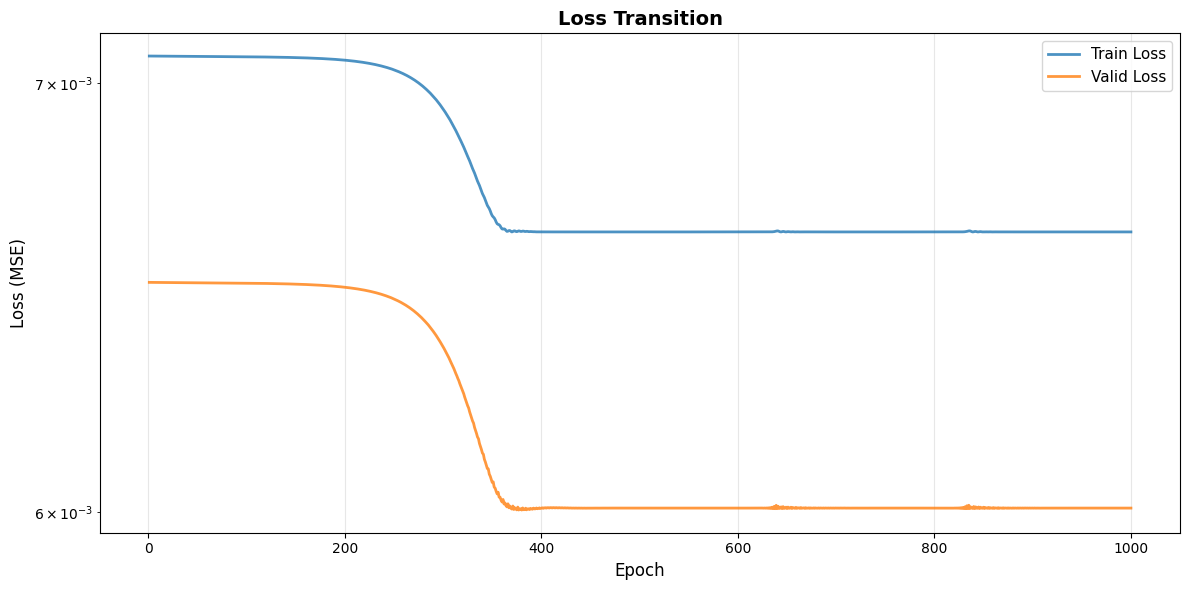

In [13]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, epochs + 1)
ax.plot(epochs_list, loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8)
ax.plot(epochs_list, loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "loss_transition", result_dir, "Lossの遷移")


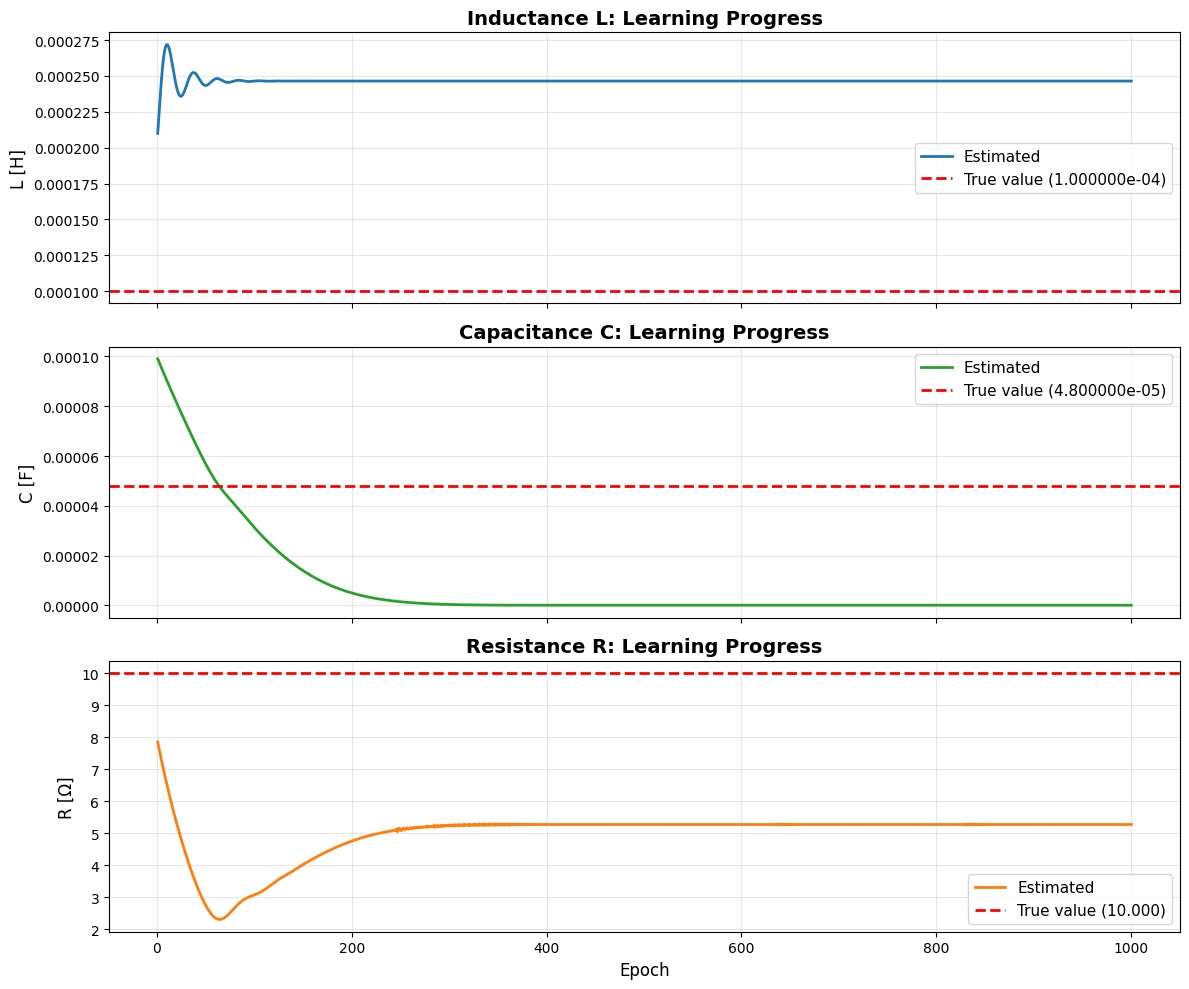

In [14]:
# 回路パラメータの学習による変化をグラフ表示
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

epochs_list = range(1, epochs + 1)

# Lの変化
axs[0].plot(
    epochs_list, param_history["L"], label="Estimated", linewidth=2, color="tab:blue"
)
axs[0].axhline(
    y=L_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({L_true:.6e})",
)
axs[0].set_ylabel("L [H]", fontsize=12)
axs[0].set_title("Inductance L: Learning Progress", fontsize=14, fontweight="bold")
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# Cの変化
axs[1].plot(
    epochs_list, param_history["C"], label="Estimated", linewidth=2, color="tab:green"
)
axs[1].axhline(
    y=C_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({C_true:.6e})",
)
axs[1].set_ylabel("C [F]", fontsize=12)
axs[1].set_title("Capacitance C: Learning Progress", fontsize=14, fontweight="bold")
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

# Rの変化
axs[2].plot(
    epochs_list, param_history["R"], label="Estimated", linewidth=2, color="tab:orange"
)
axs[2].axhline(
    y=R_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({R_true:.3f})",
)
axs[2].set_ylabel("R [Ω]", fontsize=12)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_title("Resistance R: Learning Progress", fontsize=14, fontweight="bold")
axs[2].grid(True, alpha=0.3)
axs[2].legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig, "parameter_learning", result_dir, "回路パラメータの学習による変化"
    )


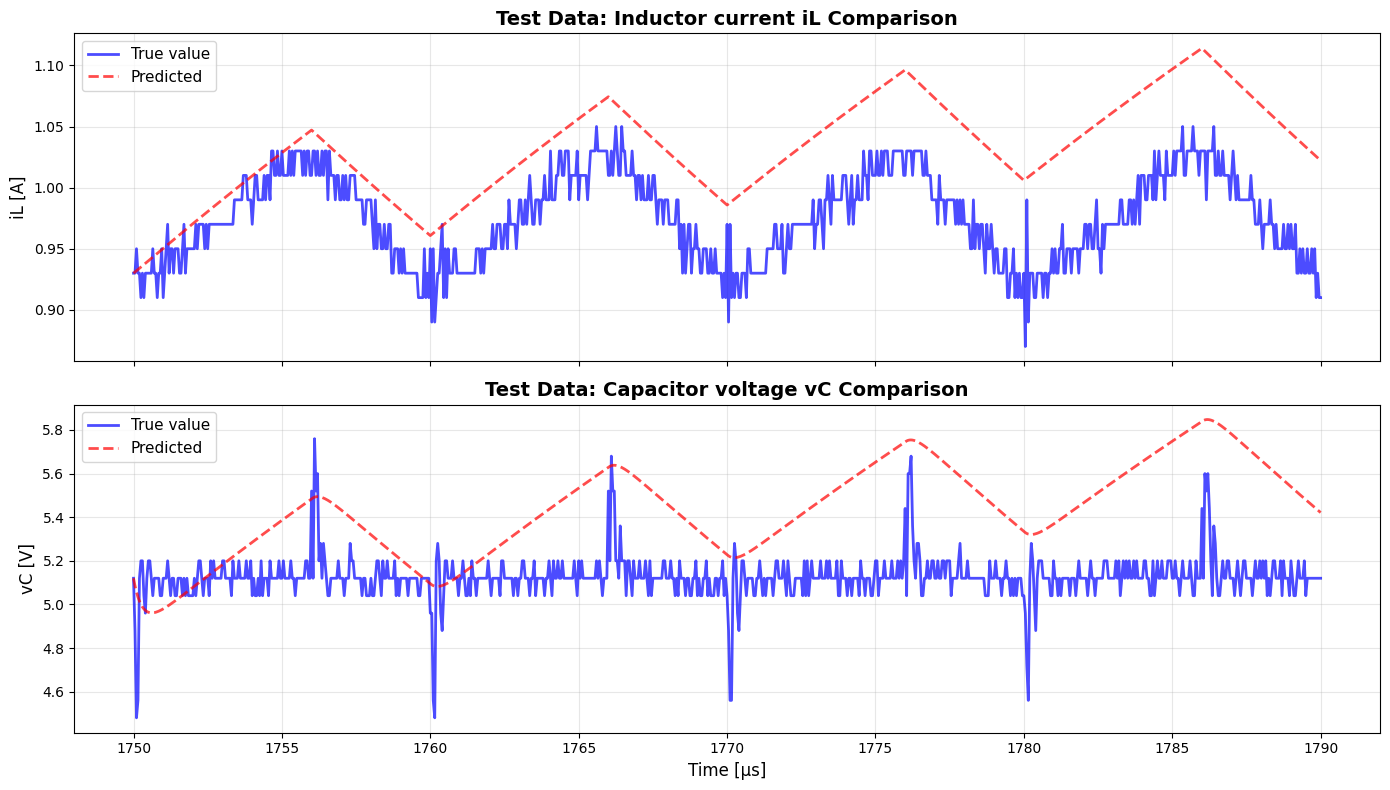

In [15]:
# テストデータでの予測結果を取得
il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = h_test[0].unsqueeze(0)
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t_test) - 1):
        h_current = buck_converter_cell(h_current, x_test[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C


iL_test_pred = torch.tensor(np.array(il_list), dtype=torch.float32)
vC_test_pred = torch.tensor(np.array(vc_list), dtype=torch.float32)


# グラフ表示
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# iLの比較
axs[0].plot(
    t_test * 1e6,
    iL_test,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[0].plot(
    t_test * 1e6,
    iL_test_pred,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[0].set_ylabel("iL [A]", fontsize=12)
axs[0].set_title(
    "Test Data: Inductor current iL Comparison", fontsize=14, fontweight="bold"
)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# vCの比較
axs[1].plot(
    t_test * 1e6,
    vC_test,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[1].plot(
    t_test * 1e6,
    vC_test_pred,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[1].set_ylabel("vC [V]", fontsize=12)
axs[1].set_xlabel("Time [μs]", fontsize=12)
axs[1].set_title(
    "Test Data: Capacitor voltage vC Comparison", fontsize=14, fontweight="bold"
)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "test_prediction", result_dir, "テストデータでの予測結果")


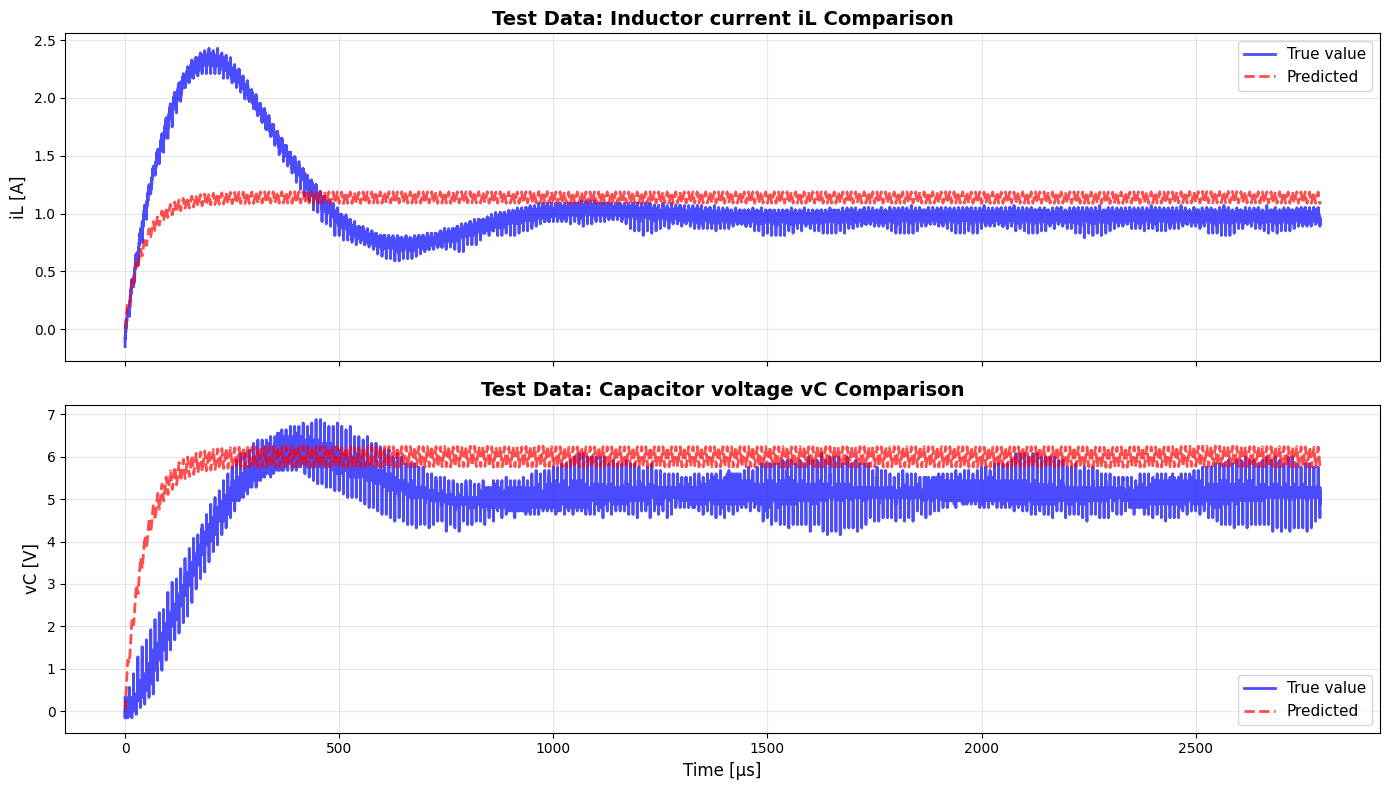

In [16]:
dt: np.ndarray = np.diff(t_all)

# スイッチング信号
duty_phase = (t_all[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t_all) - 1) * Vin

x_tensor = torch.tensor(np.c_[vs, u, dt], dtype=torch.float32)

il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t_all) - 1):
        h_current = buck_converter_cell(h_current, x_tensor[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C


iL_sim = torch.tensor(np.array(il_list), dtype=torch.float32)
vC_sim = torch.tensor(np.array(vc_list), dtype=torch.float32)


# グラフ表示
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# iLの比較
axs[0].plot(
    t_all * 1e6,
    iL_all,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[0].plot(
    t_all * 1e6,
    iL_sim,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[0].set_ylabel("iL [A]", fontsize=12)
axs[0].set_title(
    "Test Data: Inductor current iL Comparison", fontsize=14, fontweight="bold"
)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# vCの比較
axs[1].plot(
    t_all * 1e6,
    vC_all,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[1].plot(
    t_all * 1e6,
    vC_sim,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[1].set_ylabel("vC [V]", fontsize=12)
axs[1].set_xlabel("Time [μs]", fontsize=12)
axs[1].set_title(
    "Test Data: Capacitor voltage vC Comparison", fontsize=14, fontweight="bold"
)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig,
        "all_prediction",
        result_dir,
        "シミュレーション結果",
    )


## GRU


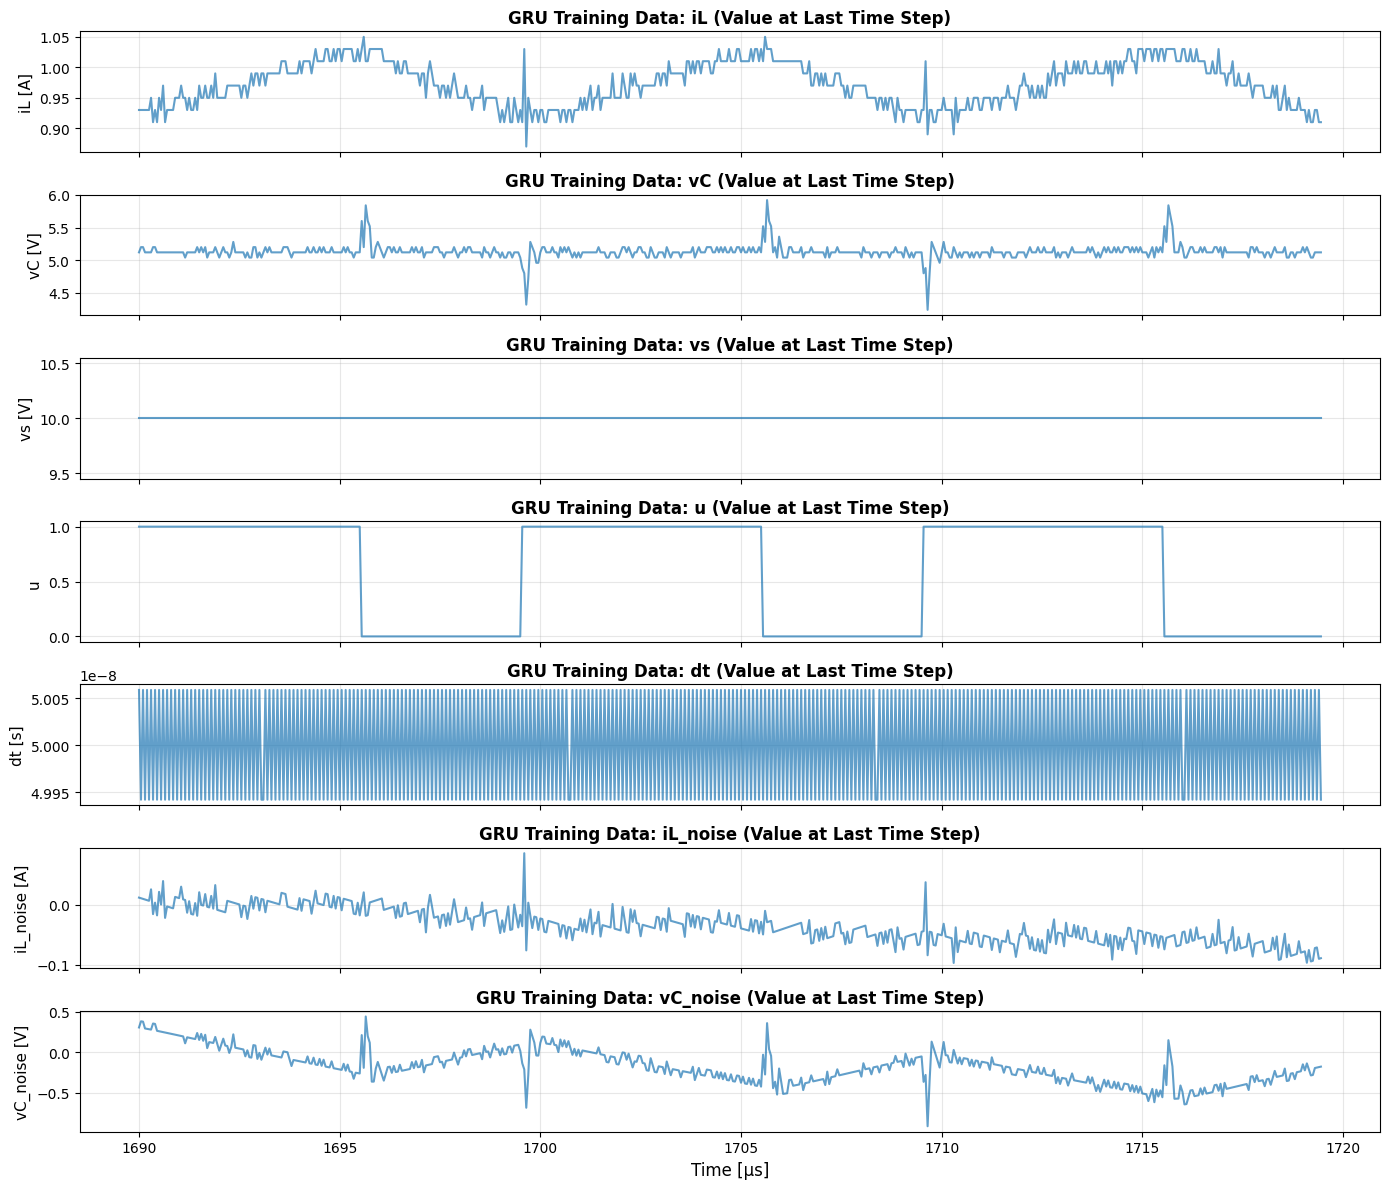

In [17]:
# 学習データ
X_train_seq_np: np.ndarray = X_train_seq.detach().cpu().numpy()
y_train_seq_np: np.ndarray = y_train_seq.detach().cpu().numpy()

# 入力特徴量名と単位
feature_names: list[str] = ["iL", "vC", "vs", "u", "dt", "iL_noise", "vC_noise"]
feature_units: list[str] = ["[A]", "[V]", "[V]", "", "[s]", "[A]", "[V]"]


fig, axs = plt.subplots(7, 1, figsize=(14, 12), sharex=True)

last_timestep_features: np.ndarray = X_train_seq_np[:, -1, :]  # [N, 7]

# time_axisをt_train（μs単位）に
time_axis: np.ndarray = t_train[: X_train_seq_np.shape[0]] * 1e6  # μs

for i in range(7):
    axs[i].plot(time_axis, last_timestep_features[:, i], linewidth=1.5, alpha=0.7)
    axs[i].set_ylabel(f"{feature_names[i]} {feature_units[i]}", fontsize=11)
    axs[i].grid(True, alpha=0.3)
    axs[i].set_title(
        f"GRU Training Data: {feature_names[i]} (Value at Last Time Step)",
        fontsize=12,
        fontweight="bold",
    )

axs[6].set_xlabel("Time [μs]", fontsize=12)
plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig,
        "gru_training_data_features",
        result_dir,
        "GRU 学習データ",
    )


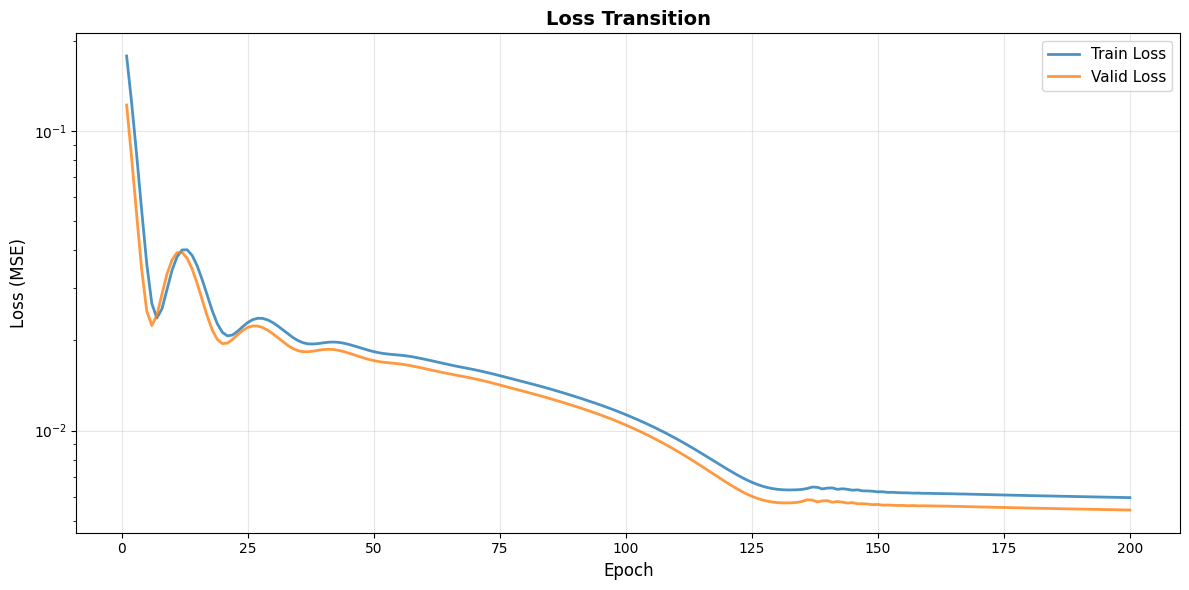

In [18]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, gru_epochs + 1)
ax.plot(
    epochs_list, gru_loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8
)
ax.plot(
    epochs_list, gru_loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8
)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "loss_transition", result_dir, "Lossの遷移")


## BuckConverterCell + GRU

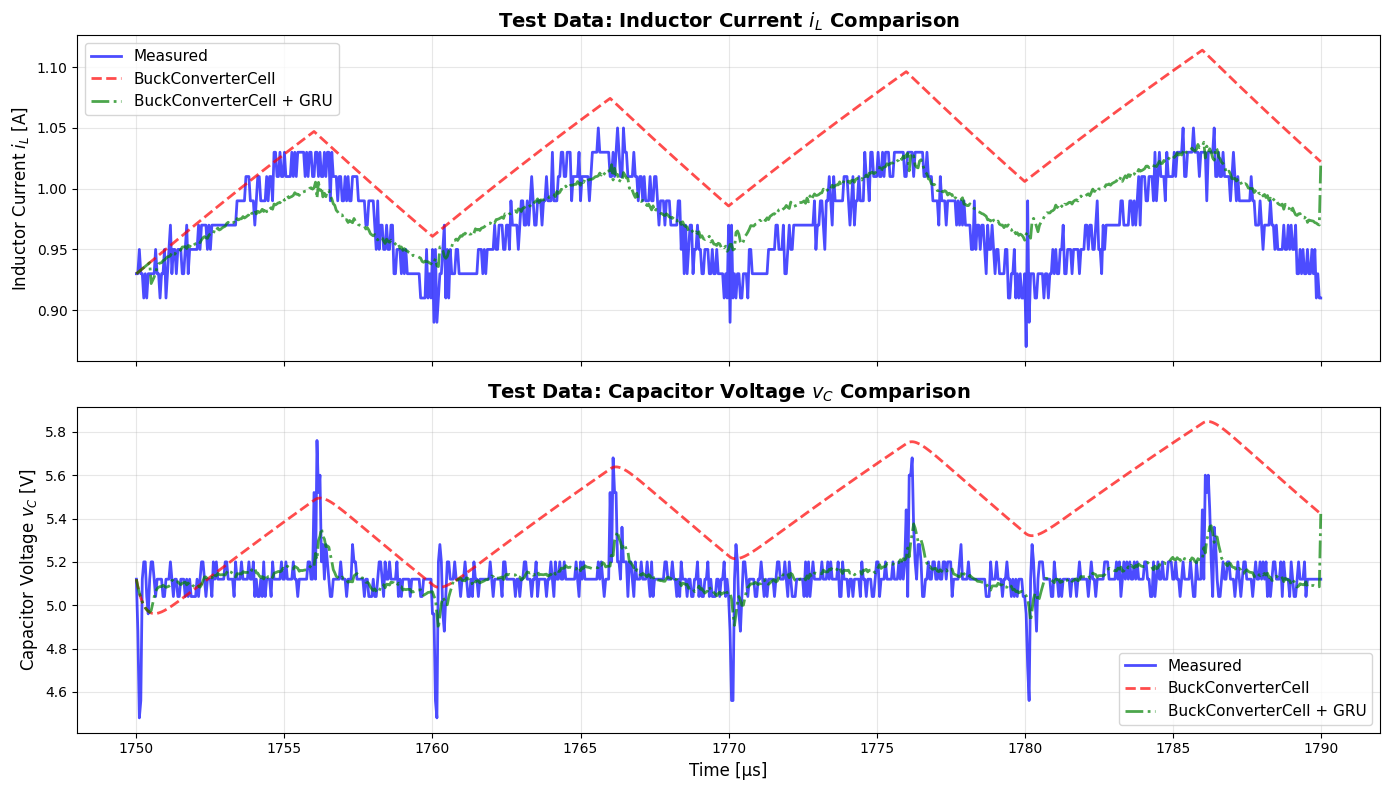

In [19]:
# Predict with test data (get results)
il_list = []
vc_list = []

# Simulate with BuckConverterCell
with torch.no_grad():
    h_current: torch.Tensor = h_test[0].unsqueeze(0)
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t_test) - 1):
        h_current = buck_converter_cell(h_current, x_test[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C

iL_buck_pred = torch.tensor(np.array(il_list), dtype=torch.float32)
vC_buck_pred = torch.tensor(np.array(vc_list), dtype=torch.float32)

# Predict noise with GRU
with torch.no_grad():
    gru_model.eval()
    noise_pred = gru_model(X_test_seq)  # [batch_size, 2] = [iL_noise, vC_noise]

# Accumulate GRU predictions over time (cumulative sum)
iL_noise_cumulative = torch.zeros(len(iL_buck_pred))
vC_noise_cumulative = torch.zeros(len(vC_buck_pred))

# Initial seq_length points are zeros
for i in range(len(noise_pred)):
    idx = i + seq_length
    if idx < len(iL_noise_cumulative):
        iL_noise_cumulative[idx] = noise_pred[i, 0]
        vC_noise_cumulative[idx] = noise_pred[i, 1]

# Combine BuckConverterCell predictions and GRU noise predictions
iL_combined = iL_buck_pred + iL_noise_cumulative
vC_combined = vC_buck_pred + vC_noise_cumulative

# Extract ground truth test part from actual data
t_test_start = t_test[0]
t_test_end = t_test[-1]

mask_test = (t_all >= t_test_start) & (t_all <= t_test_end)
t_test_actual = t_all[mask_test]
iL_test_actual = iL_all[mask_test]
vC_test_actual = vC_all[mask_test]

# Adjust lengths to the shorter one
min_len = min(len(t_test_actual), len(iL_combined))
t_test_actual = t_test_actual[:min_len]
iL_test_actual = iL_test_actual[:min_len]
vC_test_actual = vC_test_actual[:min_len]
iL_combined = iL_combined[:min_len]
vC_combined = vC_combined[:min_len]
iL_buck_pred = iL_buck_pred[:min_len]
vC_buck_pred = vC_buck_pred[:min_len]

# Plot graph (all labels/titles in English)
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# iL comparison
axs[0].plot(
    t_test_actual * 1e6,
    iL_test_actual,
    label="Measured",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[0].plot(
    t_test_actual * 1e6,
    iL_buck_pred,
    label="BuckConverterCell",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[0].plot(
    t_test_actual * 1e6,
    iL_combined,
    label="BuckConverterCell + GRU",
    linewidth=2,
    alpha=0.7,
    color="green",
    linestyle="-.",
)
axs[0].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs[0].set_title(
    "Test Data: Inductor Current $i_L$ Comparison", fontsize=14, fontweight="bold"
)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# vC comparison
axs[1].plot(
    t_test_actual * 1e6,
    vC_test_actual,
    label="Measured",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[1].plot(
    t_test_actual * 1e6,
    vC_buck_pred,
    label="BuckConverterCell",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[1].plot(
    t_test_actual * 1e6,
    vC_combined,
    label="BuckConverterCell + GRU",
    linewidth=2,
    alpha=0.7,
    color="green",
    linestyle="-.",
)
axs[1].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs[1].set_xlabel("Time [μs]", fontsize=12)
axs[1].set_title(
    "Test Data: Capacitor Voltage $v_C$ Comparison", fontsize=14, fontweight="bold"
)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig,
        "buck_gru_combined_comparison",
        result_dir,
        "Comparison of BuckConverterCell + GRU prediction and measured data",
    )


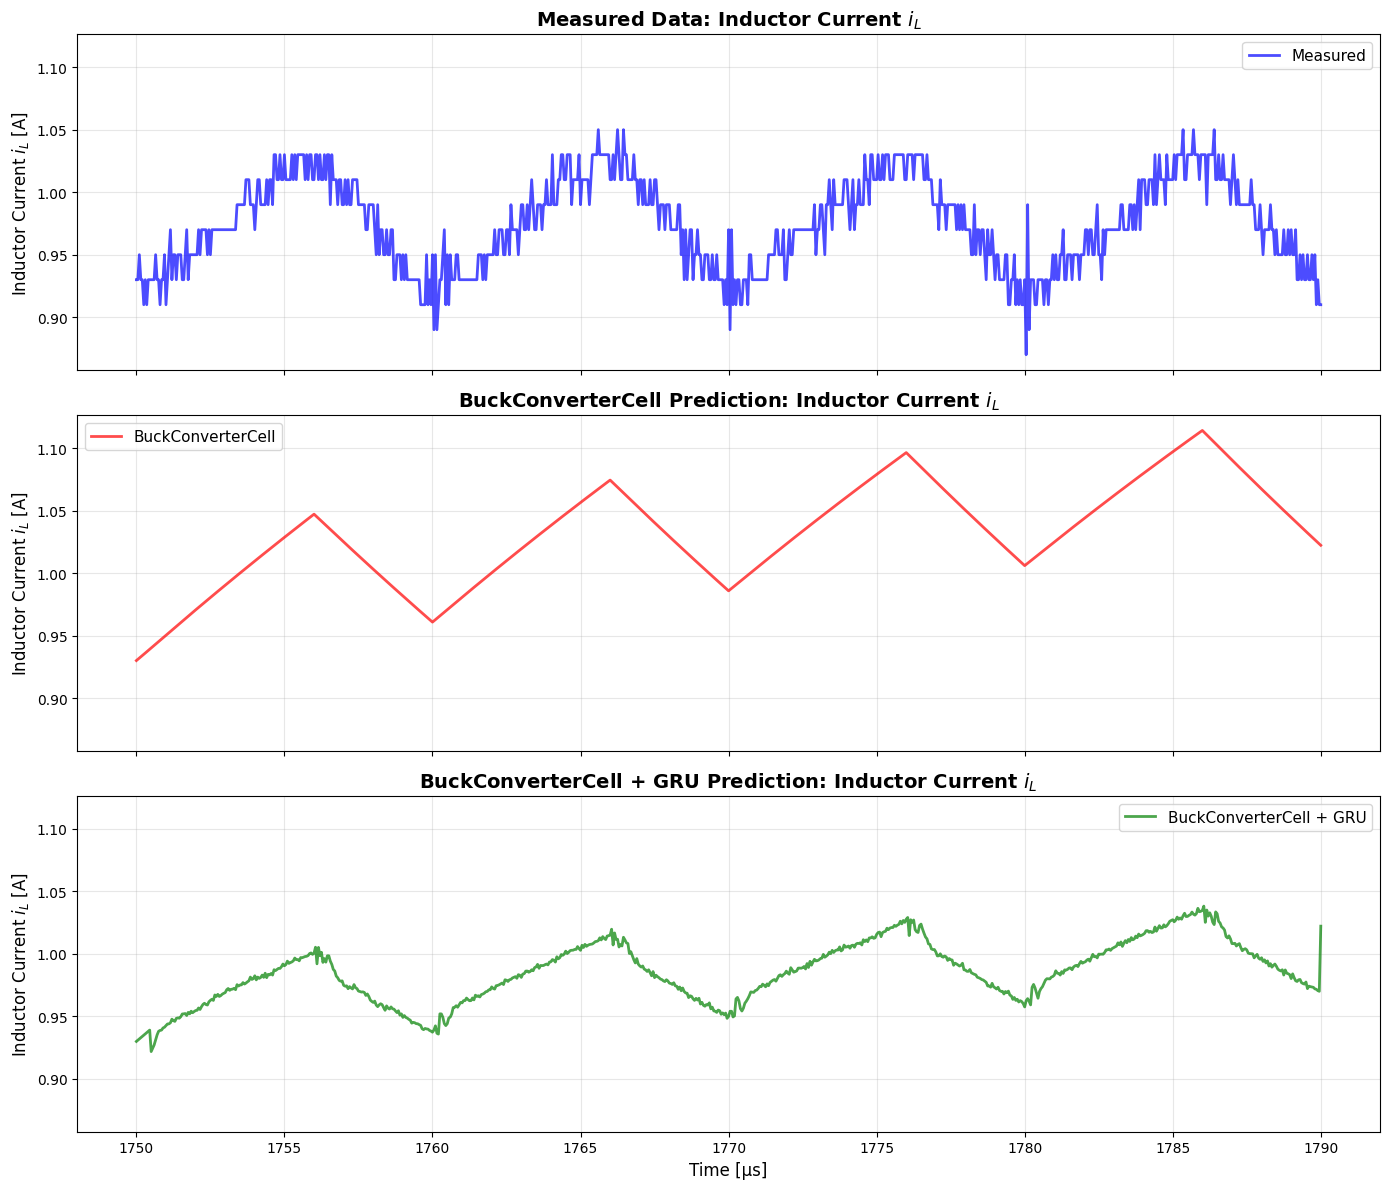

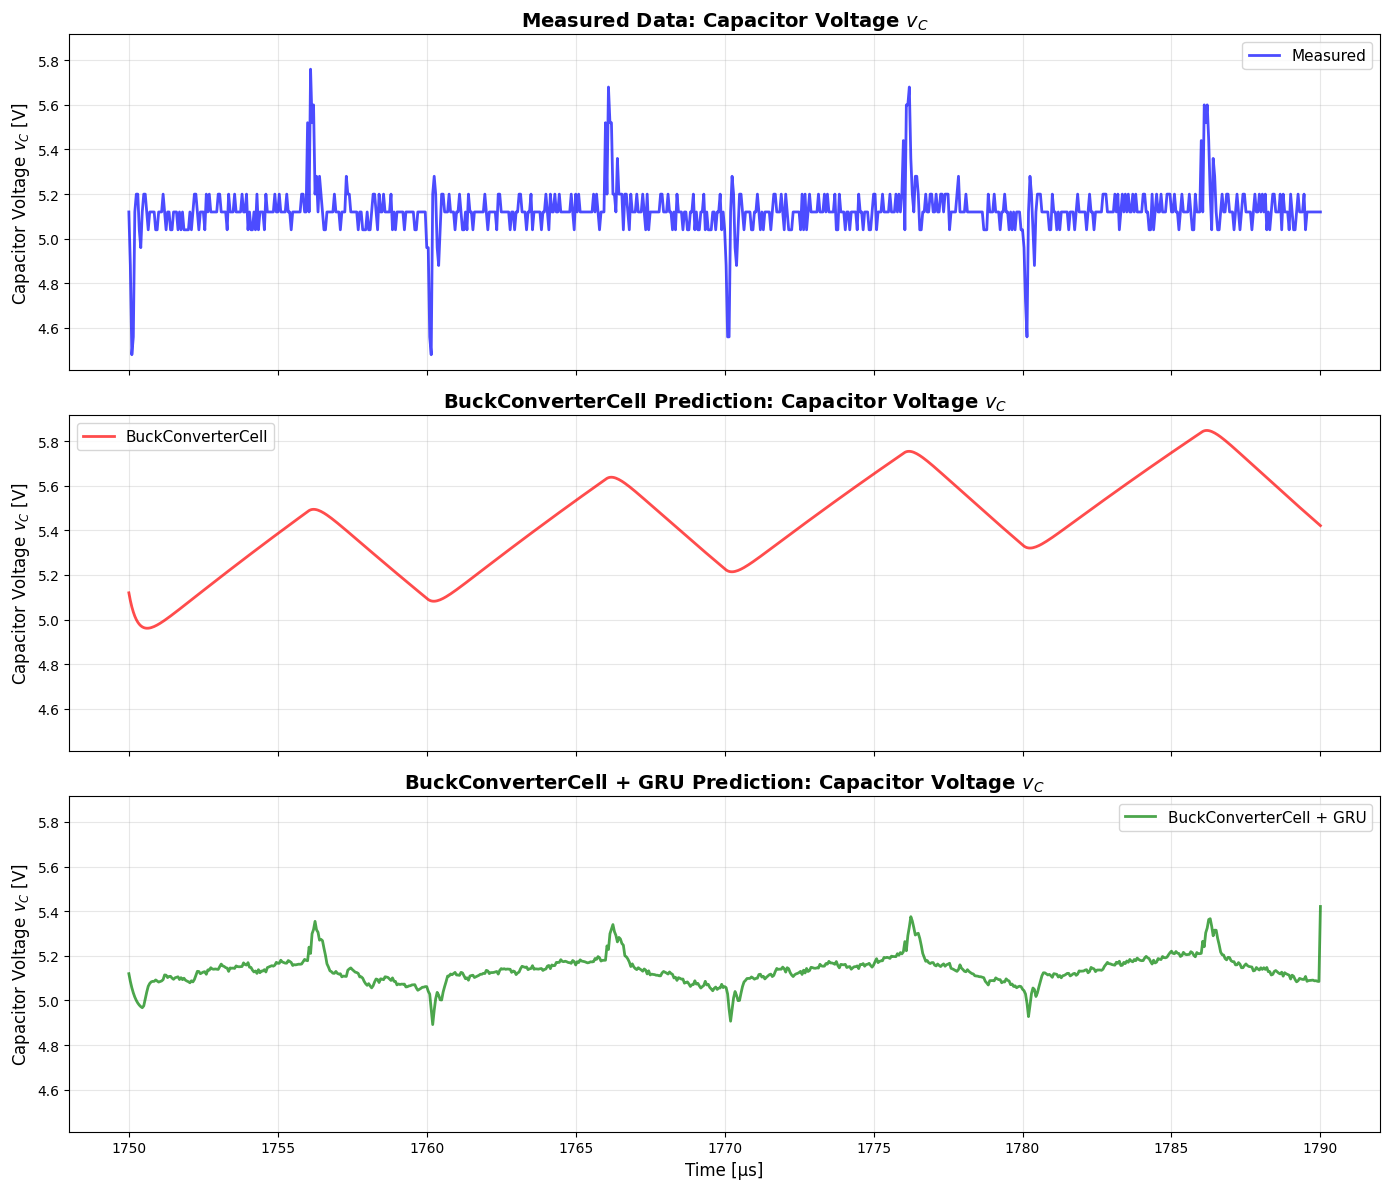

In [20]:
iL_min = min(iL_test_actual.min(), iL_buck_pred.min().item(), iL_combined.min().item())
iL_max = max(iL_test_actual.max(), iL_buck_pred.max().item(), iL_combined.max().item())
iL_range = iL_max - iL_min
iL_ylim = (iL_min - iL_range * 0.05, iL_max + iL_range * 0.05)  # 5% margin

vC_min = min(vC_test_actual.min(), vC_buck_pred.min().item(), vC_combined.min().item())
vC_max = max(vC_test_actual.max(), vC_buck_pred.max().item(), vC_combined.max().item())
vC_range = vC_max - vC_min
vC_ylim = (vC_min - vC_range * 0.05, vC_max + vC_range * 0.05)  # 5% margin

# Plot graph (separate subplots for each prediction)
# iL comparison - separate subplots
fig_iL, axs_iL = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Measured iL
axs_iL[0].plot(
    t_test_actual * 1e6,
    iL_test_actual,
    label="Measured",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs_iL[0].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[0].set_title(
    "Measured Data: Inductor Current $i_L$", fontsize=14, fontweight="bold"
)
axs_iL[0].set_ylim(iL_ylim)
axs_iL[0].grid(True, alpha=0.3)
axs_iL[0].legend(fontsize=11)

# BuckConverterCell iL
axs_iL[1].plot(
    t_test_actual * 1e6,
    iL_buck_pred,
    label="BuckConverterCell",
    linewidth=2,
    alpha=0.7,
    color="red",
)
axs_iL[1].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[1].set_title(
    "BuckConverterCell Prediction: Inductor Current $i_L$",
    fontsize=14,
    fontweight="bold",
)
axs_iL[1].set_ylim(iL_ylim)
axs_iL[1].grid(True, alpha=0.3)
axs_iL[1].legend(fontsize=11)

# BuckConverterCell + GRU iL
axs_iL[2].plot(
    t_test_actual * 1e6,
    iL_combined,
    label="BuckConverterCell + GRU",
    linewidth=2,
    alpha=0.7,
    color="green",
)
axs_iL[2].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[2].set_xlabel("Time [μs]", fontsize=12)
axs_iL[2].set_title(
    "BuckConverterCell + GRU Prediction: Inductor Current $i_L$",
    fontsize=14,
    fontweight="bold",
)
axs_iL[2].set_ylim(iL_ylim)
axs_iL[2].grid(True, alpha=0.3)
axs_iL[2].legend(fontsize=11)

plt.tight_layout()
plt.show()

# vC comparison - separate subplots
fig_vC, axs_vC = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Measured vC
axs_vC[0].plot(
    t_test_actual * 1e6,
    vC_test_actual,
    label="Measured",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs_vC[0].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[0].set_title(
    "Measured Data: Capacitor Voltage $v_C$", fontsize=14, fontweight="bold"
)
axs_vC[0].set_ylim(vC_ylim)
axs_vC[0].grid(True, alpha=0.3)
axs_vC[0].legend(fontsize=11)

# BuckConverterCell vC
axs_vC[1].plot(
    t_test_actual * 1e6,
    vC_buck_pred,
    label="BuckConverterCell",
    linewidth=2,
    alpha=0.7,
    color="red",
)
axs_vC[1].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[1].set_title(
    "BuckConverterCell Prediction: Capacitor Voltage $v_C$",
    fontsize=14,
    fontweight="bold",
)
axs_vC[1].set_ylim(vC_ylim)
axs_vC[1].grid(True, alpha=0.3)
axs_vC[1].legend(fontsize=11)

# BuckConverterCell + GRU vC
axs_vC[2].plot(
    t_test_actual * 1e6,
    vC_combined,
    label="BuckConverterCell + GRU",
    linewidth=2,
    alpha=0.7,
    color="green",
)
axs_vC[2].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[2].set_xlabel("Time [μs]", fontsize=12)
axs_vC[2].set_title(
    "BuckConverterCell + GRU Prediction: Capacitor Voltage $v_C$",
    fontsize=14,
    fontweight="bold",
)
axs_vC[2].set_ylim(vC_ylim)
axs_vC[2].grid(True, alpha=0.3)
axs_vC[2].legend(fontsize=11)

plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig_iL,
        "buck_gru_combined_iL_separate",
        result_dir,
        "Inductor Current $i_L$: Separate predictions",
    )
    save_figure_to_log(
        fig_vC,
        "buck_gru_combined_vC_separate",
        result_dir,
        "Capacitor Voltage $v_C$: Separate predictions",
    )